## Libraries

In [1]:
from datetime import datetime, timedelta, time
import xml.etree.ElementTree as ET
from IPython.core.debugger import Pdb
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import chi2
from scipy.stats import t
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import anderson
from scipy.stats import levene
from scipy.stats import mannwhitneyu
from scipy.stats import kstest
from scipy.stats import shapiro
import numpy as np
import seaborn as sns

## Reading XML File

In [2]:
file_path = "apple_health_export/other_export.xml"

tree = ET.parse(file_path)
root = tree.getroot()

## Parsing XML File

In [3]:
def mean_datetime(datetime_list):
    if not datetime_list:
        return None

    total_timestamp = sum(dt.timestamp() for dt in datetime_list)
    mean_timestamp = total_timestamp / len(datetime_list)

    mean_datetime_object = datetime.fromtimestamp(mean_timestamp)

    return mean_datetime_object

sleep_qualities = {}
raw_heart_rates = {}
binned_heart_rates = {}
step_counts = {}
walking_running = {}
respiratory_rate = {}
oxygen_saturation = {}
physical_effort = {}
basal_energy = {}
active_energy = {}
pre_binned_rate = []

date_format = "%Y-%m-%d"
time_format = "%H:%M:%S"

starting_date = datetime.strptime("2024-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
ending_date = datetime.strptime("1970-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")

flag = True

def iterate_xml(root):
    global starting_date
    global ending_date
    global flag
    counter = 0
    
    for record in root.findall(".//Record[@sourceName='Bahçeci Apple\xa0Watch’u']"):
        if record.get("type") == 'HKCategoryTypeIdentifierSleepAnalysis':
            
            value = record.get('value')
            
            start_split = record.get("startDate").split(" ")
            end_split = record.get("endDate").split(" ")
            
            start_datetime_obj = datetime.strptime(f"{start_split[0]} {start_split[1]}", f"{date_format} {time_format}")
            end_datetime_obj = datetime.strptime(f"{end_split[0]} {end_split[1]}", f"{date_format} {time_format}")
            
            
            if (start_split[0] not in sleep_qualities):
                sleep_qualities[start_split[0]] = [[value, start_datetime_obj, end_datetime_obj]]
            else:
                sleep_qualities[start_split[0]].append([value, start_datetime_obj, end_datetime_obj])
        
        
        elif record.get("type") == 'HKQuantityTypeIdentifierHeartRate':
            
            value = float(record.get("value"))
            
            start_split = record.get("startDate").split(" ")
            
            datetime_obj = datetime.strptime(start_split[0] + " " + start_split[1], date_format + " " + time_format)
            
            if datetime_obj < starting_date:
                starting_date = datetime_obj
            
            if datetime_obj > ending_date:
                ending_date = datetime_obj
            
            #Bin heart rate by using minimum 5 minute intervals, and minimum 50 events in each bin
            if flag:
                pre_binned_rate.append([value, 1, [datetime_obj], start_split[0]])
                flag = False
            else:
                pre_binned_rate[-1][0] += value
                pre_binned_rate[-1][1] += 1
                pre_binned_rate[-1][2].append(datetime_obj)
                
                if pre_binned_rate[-1][2][-1] - pre_binned_rate[-1][2][0] >= timedelta(minutes=5):
                    if pre_binned_rate[-1][1] >= 50:
                        flag = True
            
            if start_split[0] not in raw_heart_rates:
                raw_heart_rates[start_split[0]] = [[value, datetime_obj]]
            else:
                raw_heart_rates[start_split[0]].append([value, datetime_obj])

                
        elif record.get("type") == "HKQuantityTypeIdentifierStepCount":
            
            value = int(record.get("value"))
            
            start_split = record.get("startDate").split(" ")
            end_split = record.get("endDate").split(" ")
            
            start_datetime_obj = datetime.strptime(f"{start_split[0]} {start_split[1]}", f"{date_format} {time_format}")
            end_datetime_obj = datetime.strptime(f"{end_split[0]} {end_split[1]}", f"{date_format} {time_format}")
            
            if start_split[0] not in step_counts:
                step_counts[start_split[0]] = [[value, start_datetime_obj, end_datetime_obj]]
            else:
                step_counts[start_split[0]].append([value, start_datetime_obj, end_datetime_obj])
                
        elif record.get("type") == "HKQuantityTypeIdentifierRespiratoryRate":
            
            value = float(record.get("value"))
            
            start_split = record.get("startDate").split(" ")
            
            datetime_obj = datetime.strptime(f"{start_split[0]} {start_split[1]}",f"{date_format} {time_format}")
            
            if start_split[0] not in respiratory_rate:
                respiratory_rate[start_split[0]] = [[value, datetime_obj]]
            else:
                respiratory_rate[start_split[0]].append([value, datetime_obj])
                
                
        elif record.get("type") == "HKQuantityTypeIdentifierOxygenSaturation":
            # Unit: %
            value = float(record.get("value"))
            
            start_split = record.get("startDate").split(" ")
            
            datetime_obj = datetime.strptime(f"{start_split[0]} {start_split[1]}", f"{date_format} {time_format}")
            
            if start_split[0] not in oxygen_saturation:
                oxygen_saturation[start_split[0]] = [[value, datetime_obj]]
            else:
                oxygen_saturation[start_split[0]].append([value, datetime_obj])
        
        elif record.get("type") == "HKQuantityTypeIdentifierPhysicalEffort":
            # Unit: kcal/hr.kg
            value = float(record.get("value"))
            
            start_split = record.get("startDate").split(" ")
            end_split = record.get("endDate").split(" ")
            
            start_datetime_obj = datetime.strptime(f"{start_split[0]} {start_split[1]}", f"{date_format} {time_format}")
            end_datetime_obj = datetime.strptime(f"{end_split[0]} {end_split[1]}", f"{date_format} {time_format}")
            
            if start_split[0] not in physical_effort:
                physical_effort[start_split[0]] = [[value, start_datetime_obj, end_datetime_obj]]
            else:
                physical_effort[start_split[0]].append([value,start_datetime_obj, end_datetime_obj])
                
        elif record.get("type") == "HKQuantityTypeIdentifierBasalEnergyBurned":
            # Unit: kcal
            value = float(record.get("value"))
            
            start_split = record.get("startDate").split(" ")
            end_split = record.get("endDate").split(" ")
            
            start_datetime_obj = datetime.strptime(f"{start_split[0]} {start_split[1]}", f"{date_format} {time_format}")
            end_datetime_obj = datetime.strptime(f"{end_split[0]} {end_split[1]}", f"{date_format} {time_format}")
            
            if start_split[0] not in basal_energy:
                basal_energy[start_split[0]] = [[value, start_datetime_obj, end_datetime_obj]]
            else:
                basal_energy[start_split[0]].append([value,start_datetime_obj, end_datetime_obj])
                
        elif record.get("type") == "HKQuantityTypeIdentifierActiveEnergyBurned":
            # Unit: kcal
            counter += 1
            value = float(record.get("value"))
            
            start_split = record.get("startDate").split(" ")
            end_split = record.get("endDate").split(" ")
            
            start_datetime_obj = datetime.strptime(f"{start_split[0]} {start_split[1]}", f"{date_format} {time_format}")
            end_datetime_obj = datetime.strptime(f"{end_split[0]} {end_split[1]}", f"{date_format} {time_format}")
            
            if start_split[0] not in active_energy:
                active_energy[start_split[0]] = [[value, start_datetime_obj, end_datetime_obj]]
            else:
                active_energy[start_split[0]].append([value,start_datetime_obj, end_datetime_obj])

iterate_xml(root)

# Bin heart rates
binned_heart_rates = {}
for each in pre_binned_rate:
    datetime_objects = each[2]
    
    avg_value = each[0] / each[1]

    average_datetime = mean_datetime(datetime_objects)
    
    if each[3] not in binned_heart_rates:
        binned_heart_rates[each[3]] = [[avg_value, average_datetime]]
    else:
        binned_heart_rates[each[3]].append([avg_value, average_datetime])

# Read exam dates
exam_dates = []
file = open("exam_data.txt", "r")
all_lines = file.readlines()
for line in all_lines:
    line = line.strip("\n")
    dates = line.split(" ")
    first = dates[0].split(",")
    second = dates[1].split(",")
    
    first_date = first[0] + "-" + first[1] + "-" + first[2] + " " + first[3] + ":" + first[4] + ":0"
    first_date_obj = datetime.strptime(first_date, f"{date_format} {time_format}")
    
    second_date = second[0] + "-" + second[1] + "-" + second[2] + " " + second[3] + ":" + second[4] + ":0"
    second_date_obj = datetime.strptime(second_date, f"{date_format} {time_format}")
    
    exam_dates.append([first_date_obj, second_date_obj])

## Functions Used For Analysis

In [4]:
def calculate_mean(dist):
    temp = 0
    count = 0
    for i in dist:
        temp += i
        count += 1
    
    return (temp / count)

def calculate_std(dist):
    mean = calculate_mean(dist)
    variance = 0
    sample_size = len(dist)
    
    for i in dist:
        variance += (mean - i)**2
    
    variance = variance / (sample_size -1)
    stddev = variance**0.5
    
    return stddev

def chi2_goodness_of_fit(dist, alpha):
    mean = calculate_mean(dist)
    sample_std_dev = calculate_std(dist)
    sample_size = len(dist)
    
    percentiles = [i*0.1 for i in range(11)]

    percentile_values = norm.ppf(percentiles, loc=mean, scale=sample_std_dev)
    
    intervals = []
    for i in range(len(percentile_values) - 1):
        intervals.append((percentile_values[i], percentile_values[i+1]))

    count_data = [0]* 10
    for i in dist:
        for j in range(10):
            if (intervals[j][0] <= i < intervals[j][1]):
                count_data[j] += 1
                break
    
    for count in count_data:
        if count <= 5:
            print("One of the bins in chi-squared test has a count lower than 5. Chi-squared test is not reliable.")
            return
        
    expected_values = [0.1 * sample_size]*10

    observed_chi2 = 0
    for fij, eij in zip(count_data, expected_values):
        observed_chi2 += (fij - eij)**2 / eij

    p_value = chi2.sf(observed_chi2, 10 - 1 - 2)
    
    print("Chi-squared goodness of fit test for testing normality:")
    if (p_value >= alpha):
        print(f"Fail to reject the null hypothesis. The data may follow a normal distribution. P-value: {p_value}, significance level: {alpha}")
    else:
        print(f"The data does not follow a normal distribution. P-value: {p_value}, significance level: {alpha}")
    
def print_sample_statistics(dist, alpha):
    print("Sample statistics:\n")
    sample_size = len(dist)

    mean = calculate_mean(dist)
    std_dev = calculate_std(dist)
    
    minimum = min(dist)
    maximum = max(dist)
    data_range = maximum - minimum + 1
    
    z_crit = norm.ppf(1 - alpha /2)
    mean_upper_bound = mean + z_crit * std_dev / (sample_size)**0.5
    mean_lower_bound = mean - z_crit * std_dev / (sample_size)**0.5
    
    chi_upper_crit = chi2.ppf(1 - alpha /2, sample_size -1)
    chi_lower_crit = chi2.ppf(1- (1- alpha /2), sample_size - 1)

    std_upper_bound = std_dev * (sample_size - 1)**0.5 / (chi_lower_crit**0.5)
    std_lower_bound = std_dev * (sample_size - 1)**0.5 / (chi_upper_crit**0.5)
    
    sorted_dist = sorted(dist)
    
    if sample_size % 2 == 0:
        median = (sorted_dist[sample_size//2 -1] + sorted_dist[sample_size//2]) / 2
    else:
        median = (sorted_dist[sample_size//2])
    
    mean = format(mean, ".4f")
    mean_lower_bound = format(mean_lower_bound, ".4f")
    mean_upper_bound = format(mean_upper_bound, ".4f")
    std_dev = format(std_dev, ".4f")
    std_lower_bound = format(std_lower_bound, ".4f")
    std_upper_bound = format(std_upper_bound, ".4f")
    
                  
    print(f"Sample mean: {mean}, 95% confidence interval: ({mean_lower_bound}, {mean_upper_bound})")
    print(f"Sample standard deviation: {std_dev}, 95% confidence interval: ({std_lower_bound}, {std_upper_bound})")
    print(f"Median: {median}")
    print(f"Maximum point: {maximum}")
    print(f"Minimum point: {minimum}")
    print(f"Range: {data_range}")

def kolmogorov_smirnov_test(dist, alpha):
    sample_std_dev = calculate_std(dist)
    sample_mean = calculate_mean(dist)
    
    statistic, p_value = kstest(dist, 'norm', args=(sample_mean, sample_std_dev))

    print(f"Kolmogorov-Smirnov Statistic: {statistic}")
    if p_value < alpha:
        print(f"The data does not follow a normal distribution. P-value: {p_value}, significance level: {alpha}")
    else:
        print(f"Fail to reject the null hypothesis. The data may follow a normal distribution. P-value: {p_value}, significance level: {alpha}")

def anderson_test(dist):
    result = anderson(dist)

    significance_level_index = np.searchsorted(result.significance_level, 5)
    
    print("Anderson-Darling test (at 0.05 significance level):")
    if result.statistic > result.critical_values[significance_level_index]:
        print(f"The data does not follow a normal distribution. Statistic: {result.statistic}, critical value: {result.critical_values[significance_level_index]}")
    else:
        print(f"Fail to reject the null hypothesis. The data may follow a normal distribution. Statistic: {result.statistic}, critical value: {result.critical_values[significance_level_index]}")

def normality_tests(dist, alpha):
    print("Normality tests:\n")
    chi2_goodness_of_fit(dist, alpha)
    print("\n")
    kolmogorov_smirnov_test(dist, alpha)
    print("\n")
    anderson_test(dist)
    print("\n")
    
def spearman_rank_correlation(x_points, y_points, alpha):
    correlation, p_value = spearmanr(x_points, y_points)
    
    print(f"Spearman's rank correlation coefficient: {correlation}")
    if (p_value < alpha):
        print(f"The correlation is statistically significant: P-value: {p_value}, significance level: {alpha}")
    else:
        print(f"There is no significant correlation: P-value: {p_value}, significance level: {alpha}")

def pearson_correlation(x_points, y_points, alpha):
    correlation_coefficient, p_value = pearsonr(x_points, y_points)
    
    print(f"Pearson correlation coefficient: {correlation_coefficient}")
    if p_value < alpha:
        print(f"The correlation is statistically significant. P-value: {p_value}, significance level: {alpha}")
    else:
        print(f"There is no significant correlation. P-value: {p_value}, significance level: {alpha}")

def mean_above_100_for_normal(dist, alpha):
    mean = calculate_mean(dist)
    sample_std_dev = calculate_std(dist)
    sample_size = len(dist)
    
    t_obs = (mean - 100) / sample_std_dev * (sample_size)**0.5
    
    p_value = t.sf(t_obs, df=(sample_size - 1))
    
    print("Hypothesis testing: Ho: m=100 vs H1: m>100:")
    if p_value >= alpha:
        print(f"Rejecting alternative hypothesis. The mean is not bigger than 100. P-value: {p_value}, significance level: {alpha}")
    else:
        print(f"Rejecting the null hypothesis. The mean is bigger than 100. P-value: {p_value}, significance level: {alpha}")
    
def mean_above_100_for_nonnormal(dist, alpha):
    mean = calculate_mean(dist)
    sample_std_dev = calculate_std(dist)
    sample_size = len(dist)
    
    if sample_size < 30:
        print("Sample size is not large enough for using CLT for normality approximation.")
        return
    
    z_obs = (mean - 100) / sample_std_dev * (sample_size)**0.5
    
    p_value = norm.sf(z_obs)
    
    print("Hypothesis testing: Ho: m=100 vs H1: m>100:")
    if p_value >= alpha:
        print(f"Rejecting alternative hypothesis. The mean is not bigger than 100. P-value: {p_value}, significance level: {alpha}")
    else:
        print(f"Rejecting the null hypothesis. The mean is bigger than 100. P-value: {p_value}, significance level: {alpha}")

def mean_above_100_tests(dist, alpha):
    print("Hypothesis tests for testing whether the mean is larger than 100 or not:")
    print("\n")
    print("Assuming the population is normally distributed:")
    mean_above_100_for_normal(dist, alpha)
    print("\n\n")
    print("Assuming the population is not normally distributed:")
    mean_above_100_for_nonnormal(dist, alpha)
    print("\n")
    
def levene_test(dist1, dist2, alpha):
    statistic, p_value = levene(dist1, dist2, center='median')

    print(f"Levene Statistic: {statistic}")
    if p_value < alpha:
        print(f"Rejecting null hypothesis. Variances are not equal. P-value: {p_value}, significance level: {alpha}")
    else:
        print(f"Rejecting alternative hypothesis. Variances are equal. P-value: {p_value}, significance level: {alpha}")

def mann_whitneyu_test(dist1, dist2, alpha):
    statistic, p_value = mannwhitneyu(dist1, dist2)

    print(f"Mann-Whitney U Statistic: {statistic}")
    if p_value < alpha:
        print(f"There is a significant difference between the groups. P-value: {p_value}, significance level: {alpha}")
    else:
        print(f"There is no significant difference between the groups. P-value: {p_value}, significance level: {alpha}")

# General Heart Rate Distribution (All sub-distributions included) 

<br>

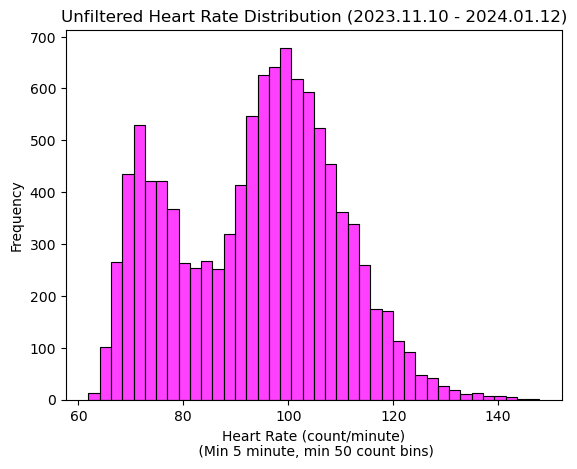

In [5]:
# Distribution of observed heart rate, using 10 minute bins
binned_heart_rate_distribution = []

for i, j in binned_heart_rates.items():
    for value in j:
        binned_heart_rate_distribution.append(value[0])

binned_heart_rate_distribution = np.array(binned_heart_rate_distribution)

sns.histplot(binned_heart_rate_distribution, bins=40, kde=False, color='magenta')

plt.title(f'Unfiltered Heart Rate Distribution ({datetime.strftime(starting_date, date_format).replace("-", ".")} - {datetime.strftime(ending_date, date_format).replace("-", ".")})')
plt.xlabel('Heart Rate (count/minute)\n (Min 5 minute, min 50 count bins)')
plt.ylabel('Frequency')
plt.show()

In [6]:
print("\n================================================\n")
print_sample_statistics(binned_heart_rate_distribution, 0.05)
print("\n================================================\n")
normality_tests(binned_heart_rate_distribution, 0.05)
print("\n================================================\n")
mean_above_100_tests(binned_heart_rate_distribution, 0.05)



Sample statistics:

Sample mean: 93.8318, 95% confidence interval: (93.5390, 94.1246)
Sample standard deviation: 15.4478, 95% confidence interval: (15.2435, 15.6577)
Median: 95.80327868852459
Maximum point: 147.83636363636364
Minimum point: 61.91803278688525
Range: 86.9183308494784


Normality tests:

Chi-squared goodness of fit test for testing normality:
The data does not follow a normal distribution. P-value: 2.443037048209878e-192, significance level: 0.05


Kolmogorov-Smirnov Statistic: 0.0713880947270861
The data does not follow a normal distribution. P-value: 7.841653272814858e-48, significance level: 0.05


Anderson-Darling test (at 0.05 significance level):
The data does not follow a normal distribution. Statistic: 91.22585609392627, critical value: 0.576




Hypothesis tests for testing whether the mean is larger than 100 or not:


Assuming the population is normally distributed:
Hypothesis testing: Ho: m=100 vs H1: m>100:
Rejecting alternative hypothesis. The mean is not b

# Sleeping Heart Rate Distribution

<br>

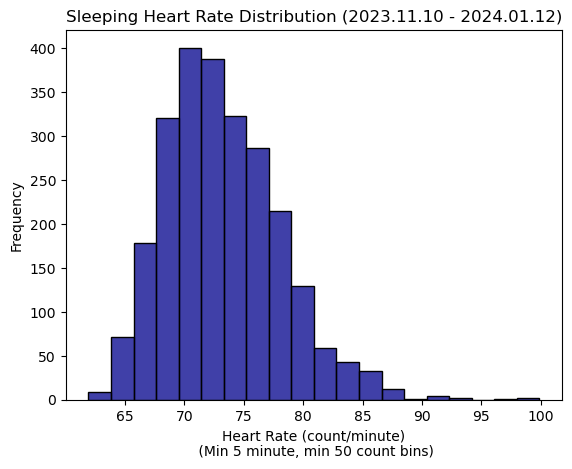

In [7]:
sleeping_intervals = []

for val in sleep_qualities.values():
    for each_interval in val:
        if each_interval[0] == "HKCategoryValueSleepAnalysisAsleepCore" or each_interval[0] == "HKCategoryValueSleepAnalysisAsleepDeep" or each_interval[0] == "HKCategoryValueSleepAnalysisAsleepREM":
            sleeping_intervals.append((each_interval[1], each_interval[2]))

sleep_dist = []
sleep_dict = {}

last_index = 0
for i, j in binned_heart_rates.items():
    for val in j:        
        counter = 0
        for each_interval in sleeping_intervals[last_index:]:
            if each_interval[0] <= val[1] < each_interval[1]:
                last_index = counter
                sleep_dist.append(val[0])
                
                sleep_dict[val[1]] = val[0]
            counter += 1

sleep_dist = np.array(sleep_dist)

sns.histplot(sleep_dist, bins=20, kde=False, color='darkblue')

plt.title(f'Sleeping Heart Rate Distribution ({datetime.strftime(starting_date, date_format).replace("-", ".")} - {datetime.strftime(ending_date, date_format).replace("-", ".")})')
plt.xlabel('Heart Rate (count/minute)\n (Min 5 minute, min 50 count bins)')
plt.ylabel('Frequency')
plt.show()

In [8]:
print("\n================================================\n")
print_sample_statistics(sleep_dist, 0.05)
print("\n================================================\n")
normality_tests(sleep_dist, 0.05)
print("\n================================================\n")
mean_above_100_tests(sleep_dist, 0.05)



Sample statistics:

Sample mean: 73.2218, 95% confidence interval: (73.0318, 73.4117)
Sample standard deviation: 4.8237, 95% confidence interval: (4.6930, 4.9619)
Median: 72.61290322580645
Maximum point: 99.875
Minimum point: 61.91803278688525
Range: 38.95696721311475


Normality tests:

Chi-squared goodness of fit test for testing normality:
The data does not follow a normal distribution. P-value: 1.29116107845452e-11, significance level: 0.05


Kolmogorov-Smirnov Statistic: 0.05368462294700599
The data does not follow a normal distribution. P-value: 1.2060391015846366e-06, significance level: 0.05


Anderson-Darling test (at 0.05 significance level):
The data does not follow a normal distribution. Statistic: 12.129350657203304, critical value: 0.575




Hypothesis tests for testing whether the mean is larger than 100 or not:


Assuming the population is normally distributed:
Hypothesis testing: Ho: m=100 vs H1: m>100:
Rejecting alternative hypothesis. The mean is not bigger than 10

## Sleeping Stages Boxplot

<br>

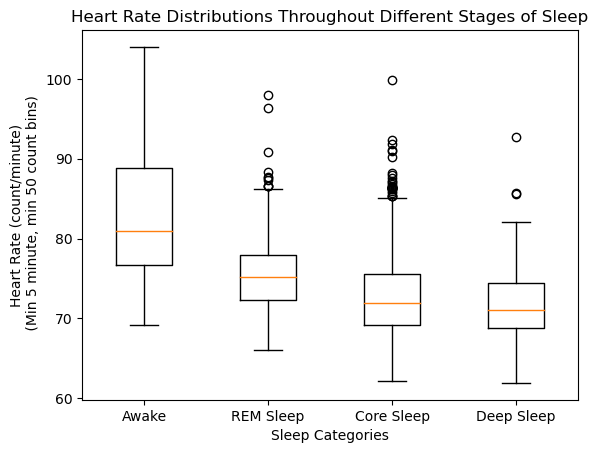

In [9]:
sleep_rem= []
sleep_core = []
sleep_deep = []
sleep_awake = []

for i, j in sleep_qualities.items():
    for sleep_data in j:

        for heart_rate_event in binned_heart_rates[i]:
            if sleep_data[1] <= heart_rate_event[1] < sleep_data[2]:
                if sleep_data[0] == "HKCategoryValueSleepAnalysisAsleepCore":
                    sleep_core.append(heart_rate_event[0])
                elif sleep_data[0] == "HKCategoryValueSleepAnalysisAsleepDeep":
                    sleep_deep.append(heart_rate_event[0])
                elif sleep_data[0] == "HKCategoryValueSleepAnalysisAsleepREM":
                    sleep_rem.append(heart_rate_event[0])
                elif sleep_data[0] == "HKCategoryValueSleepAnalysisAwake":
                    sleep_awake.append(heart_rate_event[0])
                
sleeping_dict = {"Awake": sleep_awake,
                "REM Sleep": sleep_rem,
                "Core Sleep": sleep_core,
                "Deep Sleep": sleep_deep}

plt.boxplot(sleeping_dict.values(), labels=sleeping_dict.keys())
plt.title('Heart Rate Distributions Throughout Different Stages of Sleep')
plt.xlabel('Sleep Categories')
plt.ylabel('Heart Rate (count/minute)\n (Min 5 minute, min 50 count bins)')
plt.show()

## General Heart Rate Distribution (Sleep Filtered)

<br>

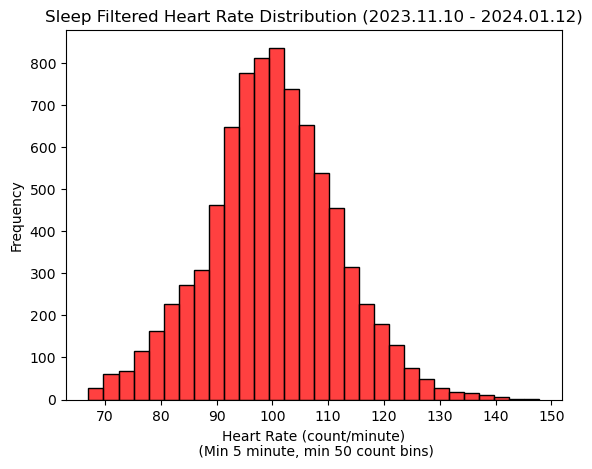

In [10]:
# Sleeping intervals subtracted heart rate distribution

sleep_filtered_dist = []
sleep_filtered_dict = {}
for i, j in binned_heart_rates.items():
    for val in j:
        
        flag = False
        for each_interval in sleeping_intervals:
            if (each_interval[0] <= val[1] <= each_interval[1]):
                flag = True
        
        if (flag == False):
            sleep_filtered_dist.append(val[0])
            
            if i not in sleep_filtered_dict:
                sleep_filtered_dict[i] = [[val[0], val[1]]]
            else:
                sleep_filtered_dict[i].append([val[0], val[1]])

sleep_filtered_dist = np.array(sleep_filtered_dist)

sns.histplot(sleep_filtered_dist, bins=30, kde=False, color='red')

plt.title(f'Sleep Filtered Heart Rate Distribution ({datetime.strftime(starting_date, date_format).replace("-", ".")} - {datetime.strftime(ending_date, date_format).replace("-", ".")})')
plt.xlabel('Heart Rate (count/minute)\n (Min 5 minute, min 50 count bins)')
plt.ylabel('Frequency')
plt.show()

In [11]:
print("\n================================================\n")
print_sample_statistics(sleep_filtered_dist, 0.05)
print("\n================================================\n")
normality_tests(sleep_filtered_dist, 0.05)
print("\n================================================\n")
mean_above_100_tests(sleep_filtered_dist, 0.05)



Sample statistics:

Sample mean: 100.0454, 95% confidence interval: (99.7924, 100.2984)
Sample standard deviation: 11.6997, 95% confidence interval: (11.5235, 11.8814)
Median: 99.89262295081969
Maximum point: 147.83636363636364
Minimum point: 67.03225806451613
Range: 81.80410557184751


Normality tests:

Chi-squared goodness of fit test for testing normality:
The data does not follow a normal distribution. P-value: 1.5239464795201553e-11, significance level: 0.05


Kolmogorov-Smirnov Statistic: 0.020957734316391863
The data does not follow a normal distribution. P-value: 0.001446356393046136, significance level: 0.05


Anderson-Darling test (at 0.05 significance level):
The data does not follow a normal distribution. Statistic: 5.7719419737913995, critical value: 0.576




Hypothesis tests for testing whether the mean is larger than 100 or not:


Assuming the population is normally distributed:
Hypothesis testing: Ho: m=100 vs H1: m>100:
Rejecting alternative hypothesis. The mean is 

## Heart Rate While Moving

<br>

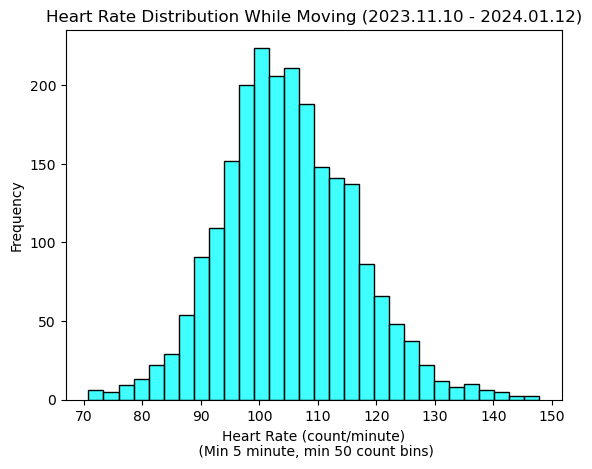

In [12]:
steps_dist = []

for i, j in binned_heart_rates.items():
    for val in j:
        
        for k in step_counts[i]:
            if (k[1] <= val[1] < k[2]):
                steps_dist.append(val[0])
                break
                
steps_dist = np.array(steps_dist)

sns.histplot(steps_dist, bins=30, kde=False, color='cyan')

plt.title(f'Heart Rate Distribution While Moving ({datetime.strftime(starting_date, date_format).replace("-", ".")} - {datetime.strftime(ending_date, date_format).replace("-", ".")})')
plt.xlabel('Heart Rate (count/minute)\n (Min 5 minute, min 50 count bins)')
plt.ylabel('Frequency')
plt.show()

In [13]:
print("\n================================================\n")
print_sample_statistics(steps_dist, 0.05)
print("\n================================================\n")
normality_tests(steps_dist, 0.05)
print("\n================================================\n")
mean_above_100_tests(steps_dist, 0.05)



Sample statistics:

Sample mean: 104.9249, 95% confidence interval: (104.4586, 105.3912)
Sample standard deviation: 11.2830, 95% confidence interval: (10.9626, 11.6227)
Median: 104.21052631578948
Maximum point: 147.83636363636364
Minimum point: 70.78947368421052
Range: 78.04688995215312


Normality tests:

Chi-squared goodness of fit test for testing normality:
The data does not follow a normal distribution. P-value: 0.0003731630981962034, significance level: 0.05


Kolmogorov-Smirnov Statistic: 0.03076284956365216
The data does not follow a normal distribution. P-value: 0.027749450092029004, significance level: 0.05


Anderson-Darling test (at 0.05 significance level):
The data does not follow a normal distribution. Statistic: 3.2447168048074673, critical value: 0.575




Hypothesis tests for testing whether the mean is larger than 100 or not:


Assuming the population is normally distributed:
Hypothesis testing: Ho: m=100 vs H1: m>100:
Rejecting the null hypothesis. The mean is big

## General Heart Rate Distribution (Sleep and Moving Distributions Filtered)

<br>

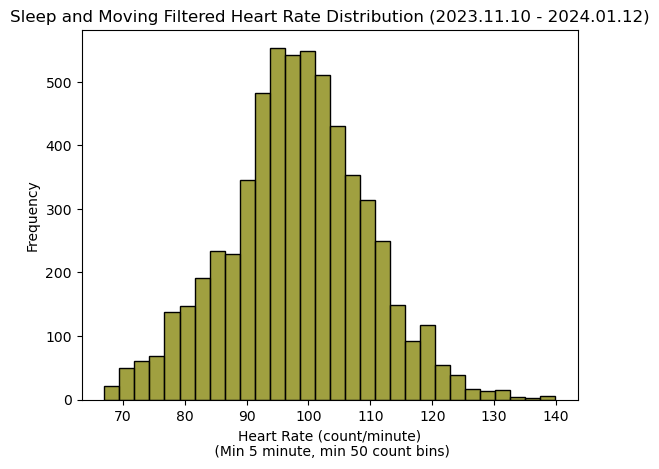

In [14]:
# Observed Heart Rate Distribution (Sleep and Moving distributions filtered)
sleep_steps_filtered_dist = []
for i, j in sleep_filtered_dict.items():
    for val in j:
        flag = True
        for k in step_counts[i]:
            if (k[1] <= val[1] < k[2]):
                flag = False
                break
        
        if flag:
            sleep_steps_filtered_dist.append(val[0])

sns.histplot(sleep_steps_filtered_dist, bins=30, kde=False, color='olive')

plt.title(f'Sleep and Moving Filtered Heart Rate Distribution ({datetime.strftime(starting_date, date_format).replace("-", ".")} - {datetime.strftime(ending_date, date_format).replace("-", ".")})')
plt.xlabel('Heart Rate (count/minute)\n (Min 5 minute, min 50 count bins)')
plt.ylabel('Frequency')
plt.show()

In [15]:
print("\n================================================\n")
print_sample_statistics(sleep_steps_filtered_dist, 0.05)
print("\n================================================\n")
normality_tests(sleep_steps_filtered_dist, 0.05)
print("\n================================================\n")
mean_above_100_tests(sleep_steps_filtered_dist, 0.05)



Sample statistics:

Sample mean: 98.1756, 95% confidence interval: (97.8882, 98.4631)
Sample standard deviation: 11.3397, 95% confidence interval: (11.1400, 11.5467)
Median: 98.32508342602893
Maximum point: 139.86666666666667
Minimum point: 67.03225806451613
Range: 73.83440860215055


Normality tests:

Chi-squared goodness of fit test for testing normality:
The data does not follow a normal distribution. P-value: 4.163642212771542e-11, significance level: 0.05


Kolmogorov-Smirnov Statistic: 0.025248867072991288
The data does not follow a normal distribution. P-value: 0.00096199774010158, significance level: 0.05


Anderson-Darling test (at 0.05 significance level):
The data does not follow a normal distribution. Statistic: 4.332505011398098, critical value: 0.576




Hypothesis tests for testing whether the mean is larger than 100 or not:


Assuming the population is normally distributed:
Hypothesis testing: Ho: m=100 vs H1: m>100:
Rejecting alternative hypothesis. The mean is not b

## Comparing Heart Rate Distributions in Week Days vs Weekends

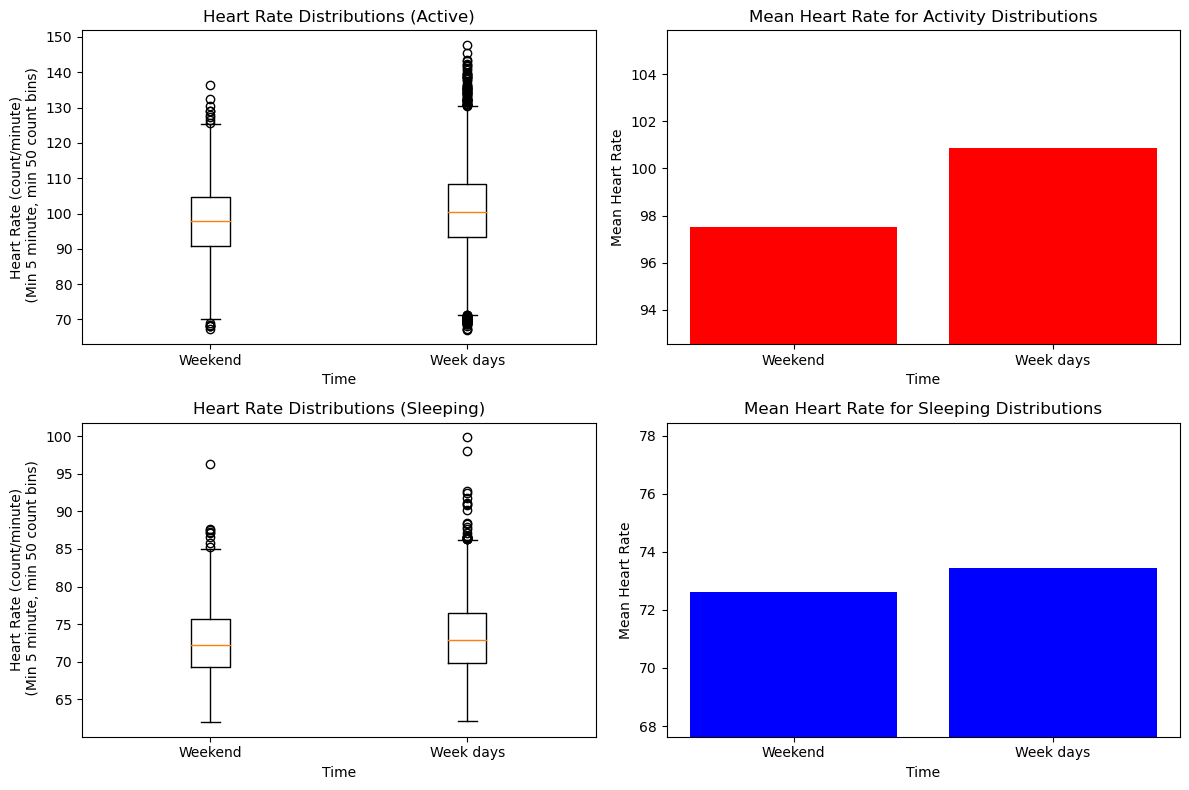

In [16]:
weekdays_active_dist = []
weekends_active_dist = []

for i, j in sleep_filtered_dict.items():
    for val in j:
        day_str = val[1].strftime('%A')
        if day_str == "Saturday" or day_str == "Sunday":
            weekends_active_dist.append(val[0])
        else:
            weekdays_active_dist.append(val[0])

week_active_dict = {"Weekend": weekends_active_dist, "Week days": weekdays_active_dist}


weekdays_sleep_dist = []
weekends_sleep_dist = []

for day, val in sleep_dict.items():
    day_str = day.strftime('%A')
    if day_str == "Saturday" or day_str == "Sunday":
        weekends_sleep_dist.append(val)
    else:
        weekdays_sleep_dist.append(val)

week_sleep_dict = {"Weekend": weekends_sleep_dist, "Week days": weekdays_sleep_dist}



fig, axes = plt.subplots(2, 2, figsize=(12, 8))


axes[0, 0].boxplot(week_active_dict.values(), labels=week_active_dict.keys())
axes[0, 0].set_title('Heart Rate Distributions (Active)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Heart Rate (count/minute)\n (Min 5 minute, min 50 count bins)')



axes[1, 0].boxplot(week_sleep_dict.values(), labels=week_sleep_dict.keys())
axes[1, 0].set_title('Heart Rate Distributions (Sleeping)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Heart Rate (count/minute)\n (Min 5 minute, min 50 count bins)')



max_value_active = max([calculate_mean(dist) for dist in week_active_dict.values()])
min_value_active = min([calculate_mean(dist) for dist in week_active_dict.values()])

axes[0, 1].set_ylim(min_value_active - 5, max_value_active + 5)
axes[0, 1].bar(week_active_dict.keys(), [calculate_mean(dist) for dist in week_active_dict.values()], color="red")
axes[0, 1].set_title('Mean Heart Rate for Activity Distributions')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Mean Heart Rate')



max_value_sleep = max([calculate_mean(dist) for dist in week_sleep_dict.values()])
min_value_sleep = min([calculate_mean(dist) for dist in week_sleep_dict.values()])

axes[1, 1].set_ylim(min_value_sleep - 5, max_value_sleep + 5)
axes[1, 1].bar(week_sleep_dict.keys(), [calculate_mean(dist) for dist in week_sleep_dict.values()], color="blue")
axes[1, 1].set_title('Mean Heart Rate for Sleeping Distributions')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Mean Heart Rate')

plt.tight_layout()
plt.show()

In [17]:
print("Weekend vs Week days Activity Distributions:\n")
print("Differences of variances test:")
levene_test(weekends_active_dist, weekdays_active_dist, 0.05)
print("\n")
print("Differences of means test:")
mann_whitneyu_test(weekends_active_dist, weekdays_active_dist, 0.05)

print("\n===========================================================\n")

print("Weekend vs Week days Activity Distributions:\n")
print("Differences of variances test:")
levene_test(weekends_sleep_dist, weekdays_sleep_dist, 0.05)
print("\n")
print("Differences of means test:")
mann_whitneyu_test(weekends_sleep_dist, weekdays_sleep_dist, 0.05)

Weekend vs Week days Activity Distributions:

Differences of variances test:
Levene Statistic: 0.8220194794332879
Rejecting alternative hypothesis. Variances are equal. P-value: 0.3646169739098253, significance level: 0.05


Differences of means test:
Mann-Whitney U Statistic: 5311087.0
There is a significant difference between the groups. P-value: 3.269368717977862e-25, significance level: 0.05


Weekend vs Week days Activity Distributions:

Differences of variances test:
Levene Statistic: 3.791312010121224
Rejecting alternative hypothesis. Variances are equal. P-value: 0.05163221538017922, significance level: 0.05


Differences of means test:
Mann-Whitney U Statistic: 555103.5
There is a significant difference between the groups. P-value: 0.0009177847576632845, significance level: 0.05


## Analysis of Distributions of Heart Rate At Different Periods In A Day
## (Morning, Afternoon, Evening, Night, Late Night)

<br>

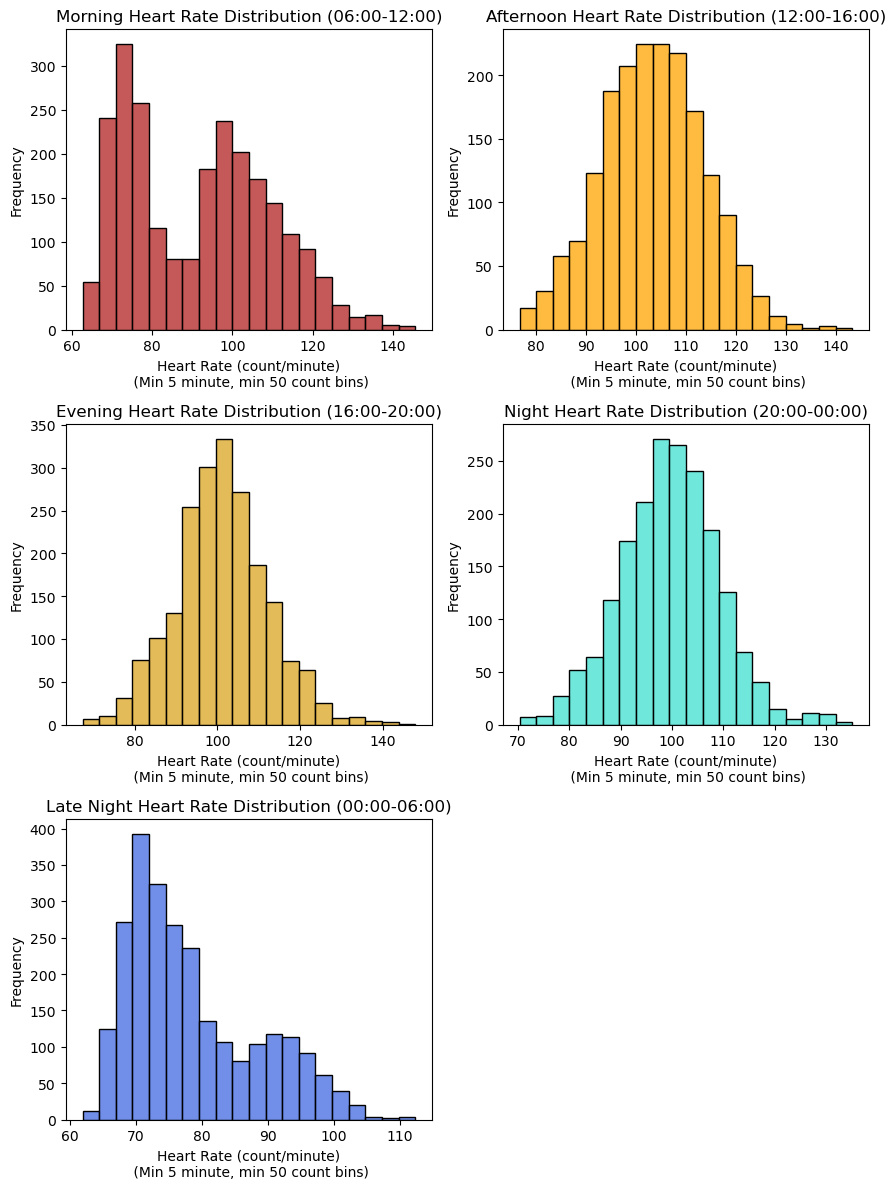

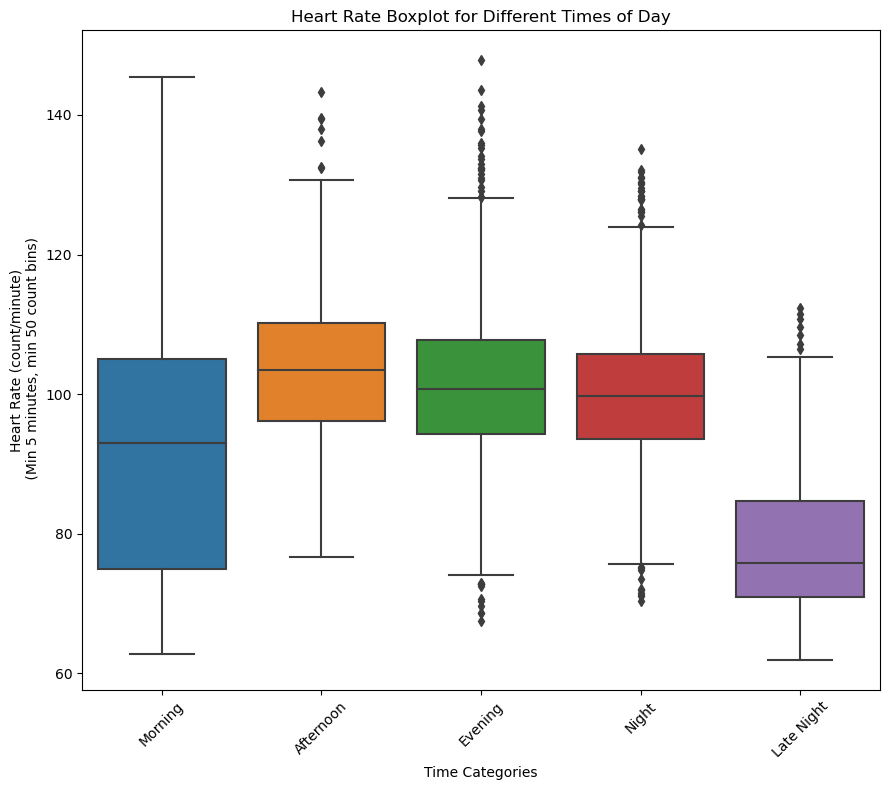



AFTERNOON DISTRIBUTION:

Sample statistics:

Sample mean: 103.4002, 95% confidence interval: (102.9319, 103.8684)
Sample standard deviation: 10.2527, 95% confidence interval: (9.9320, 10.5950)
Median: 103.39166666666668
Maximum point: 143.26
Minimum point: 76.68852459016394
Range: 67.57147540983605


Normality tests:

Chi-squared goodness of fit test for testing normality:
Fail to reject the null hypothesis. The data may follow a normal distribution. P-value: 0.9872196548789881, significance level: 0.05


Kolmogorov-Smirnov Statistic: 0.012856536980526967
Fail to reject the null hypothesis. The data may follow a normal distribution. P-value: 0.9170780747663357, significance level: 0.05


Anderson-Darling test (at 0.05 significance level):
Fail to reject the null hypothesis. The data may follow a normal distribution. Statistic: 0.2605054977132113, critical value: 0.575




Hypothesis tests for testing whether the mean is larger than 100 or not:


Assuming the population is normally di

In [18]:
# How does the distribution of my heart rate change during different times in a day?

colors = ["firebrick", "orange", "goldenrod", "turquoise", "royalblue"]
times = [(time(6,0,0), time(12,0,0)), (time(12,0,0), time(16,0,0)), (time(16,0,0), time(20,0,0)), (time(20,0,0), time(23,59,59)), (time(0,0,0), time(6,0,0))]
label_times = ["06:00-12:00", "12:00-16:00", "16:00-20:00", "20:00-00:00", "00:00-06:00"]
names = ["Morning", "Afternoon", "Evening", "Night", "Late Night"]

time_distributions = []

fig, axes = plt.subplots(3, 2, figsize=(9, 12))

for count in range(len(times)):
    temp = []
    for i, j in binned_heart_rates.items():   
        
        for values in j:
            time_comp = values[1].time()
            if (times[count][0] <= time_comp <= times[count][1]):
                temp.append(values[0])

    if len(temp) != 0:
        ax = axes[count//2, count%2]
        
        sns.histplot(temp, bins=20, kde=False, color=colors[count], ax=ax)

        ax.set_title(f'{names[count]} Heart Rate Distribution ({label_times[count]})')
        ax.set_xlabel('Heart Rate (count/minute)\n (Min 5 minute, min 50 count bins)')
        ax.set_ylabel('Frequency')

        time_distributions.append([temp.copy(), names[count]])

        
fig.tight_layout()
fig.delaxes(axes[2,1])

fig2, ax_box = plt.subplots(figsize=(9, 8))

# Create a dictionary for boxplot data
time_dist_dict = {
    "Morning": time_distributions[0][0],
    "Afternoon": time_distributions[1][0],
    "Evening": time_distributions[2][0],
    "Night": time_distributions[3][0],
    "Late Night": time_distributions[4][0]
}

sns.boxplot(data=list(time_dist_dict.values()), ax=ax_box)
ax_box.set_xticklabels(list(time_dist_dict.keys()), rotation=45)
ax_box.set_title('Heart Rate Boxplot for Different Times of Day')
ax_box.set_xlabel('Time Categories')
ax_box.set_ylabel('Heart Rate (count/minute)\n (Min 5 minutes, min 50 count bins)')

plt.tight_layout()
plt.show()

print("\n=======================================================\n")
print("AFTERNOON DISTRIBUTION:\n")
print_sample_statistics(time_distributions[1][0], 0.05)
print("\n")
normality_tests(time_distributions[1][0], 0.05)
print("\n")
mean_above_100_tests(time_distributions[1][0], 0.05)

print("\n=======================================================\n")
print("EVENING DISTRIBUTION:\n")
print_sample_statistics(time_distributions[2][0], 0.05)
print("\n")
normality_tests(time_distributions[2][0], 0.05)
print("\n")
mean_above_100_tests(time_distributions[2][0], 0.05)

print("\n=======================================================\n")
print("NIGHT DISTRIBUTION:\n")
print_sample_statistics(time_distributions[3][0], 0.05)
print("\n")
normality_tests(time_distributions[3][0], 0.05)
print("\n")
mean_above_100_tests(time_distributions[3][0], 0.05)

## Analysis of Heart Rate During Exams

<br>

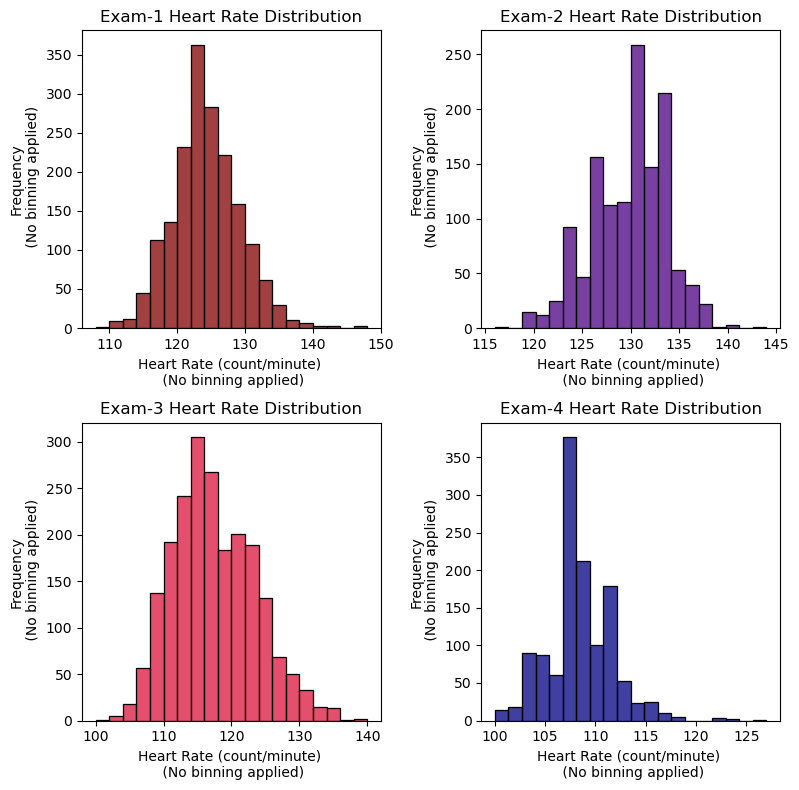

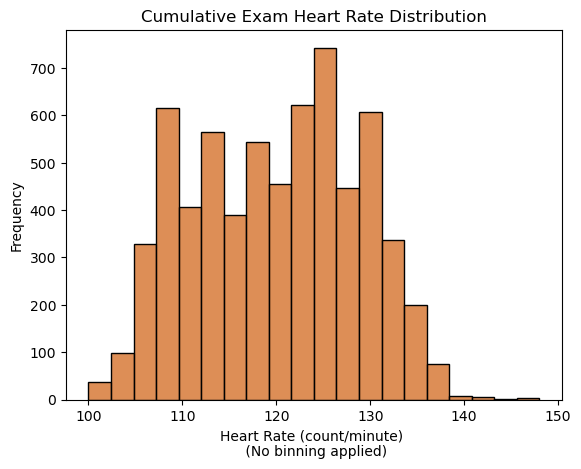



Exam-1 statistics:
Sample statistics:

Sample mean: 123.8214, 95% confidence interval: (123.5925, 124.0502)
Sample standard deviation: 4.9501, 95% confidence interval: (4.7934, 5.1174)
Median: 123.0
Maximum point: 148.0
Minimum point: 108.0
Range: 41.0


Normality tests:

Chi-squared goodness of fit test for testing normality:
The data does not follow a normal distribution. P-value: 1.8446770988004725e-29, significance level: 0.05


Kolmogorov-Smirnov Statistic: 0.07229389622364568
The data does not follow a normal distribution. P-value: 1.2999155112906176e-08, significance level: 0.05


Anderson-Darling test (at 0.05 significance level):
The data does not follow a normal distribution. Statistic: 6.430403670909527, critical value: 0.575




Hypothesis tests for testing whether the mean is larger than 100 or not:


Assuming the population is normally distributed:
Hypothesis testing: Ho: m=100 vs H1: m>100:
Rejecting the null hypothesis. The mean is bigger than 100. P-value: 0.0, signi

In [19]:
cumulative_exam_dist = []
exam_distributions = []

count = 0
colors = ["maroon", "indigo", "crimson", "navy"]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, j in raw_heart_rates.items():
    temp = []
    for values in j:
        for k in exam_dates:
            if (k[0] <= values[1] <= k[1]):
                temp.append(values[0])
                cumulative_exam_dist.append(values[0])
                break
    
    if len(temp) != 0:
        ax = axes[count//2, count%2]
        
        sns.histplot(temp, bins=20, kde=False, color=colors[count], ax=ax)

        ax.set_title(f'Exam-{count+1} Heart Rate Distribution')
        ax.set_xlabel('Heart Rate (count/minute) \n (No binning applied)')
        ax.set_ylabel('Frequency\n (No binning applied)')
        
        exam_distributions.append(temp.copy())
        
        count += 1


plt.tight_layout()
plt.show()
cumulative_exam_dist = np.array(cumulative_exam_dist)


sns.histplot(cumulative_exam_dist, bins=20, kde=False, color='chocolate')

plt.title(f'Cumulative Exam Heart Rate Distribution')
plt.xlabel('Heart Rate (count/minute) \n (No binning applied)')
plt.ylabel('Frequency')
plt.show() 

count = 1
for each in exam_distributions:
    print("\n=======================================================\n")
    print(f"Exam-{count} statistics:")
    print_sample_statistics(each, 0.05)
    print("\n")
    normality_tests(each, 0.05)
    print("\n")
    mean_above_100_tests(each, 0.05)

    
    count += 1

print("\n=======================================================\n")
print("Cumulative exam statistics:")
print_sample_statistics(cumulative_exam_dist, 0.05)
print("\n")
normality_tests(cumulative_exam_dist, 0.05)
print("\n")
mean_above_100_tests(cumulative_exam_dist, 0.05)

## TESTS FOR DIFFERENCES OF MEANS AND VARIANCES FOR MULTIPLE DISTRIBUTIONS

In [20]:
# TESTS FOR DIFFERENCES OF MEANS AND VARIANCES
print("\n==============================================\n")

print("Sleep filtered vs Sleep and Movement filtered distributions:\n")
print("Differences of variances test:")
levene_test(sleep_steps_filtered_dist, sleep_filtered_dist, 0.05)
print("\n")
print("Differences of means test:")
mann_whitneyu_test(sleep_steps_filtered_dist, sleep_filtered_dist, 0.05)

print("\n==============================================\n")

print("Sleep filtered vs Movement distributions:\n")
print("Differences of variances test:")
levene_test(steps_dist, sleep_filtered_dist, 0.05)
print("\n")
print("Differences of means test:")
mann_whitneyu_test(steps_dist, sleep_filtered_dist, 0.05)

print("\n==============================================\n")

print("Afternoon vs Evening distributions:\n")
print("Differences of variances test:")
levene_test(time_distributions[1][0], time_distributions[2][0], 0.05)
print("\n")
print("Differences of means test:")
mann_whitneyu_test(time_distributions[1][0], time_distributions[2][0], 0.05)

print("\n==============================================\n")

print("Afternoon vs Night distributions:\n")
print("Differences of variances test:")
levene_test(time_distributions[1][0], time_distributions[3][0], 0.05)
print("\n")
print("Differences of means test:")
mann_whitneyu_test(time_distributions[1][0], time_distributions[3][0], 0.05)

print("\n==============================================\n")

print("Evening vs Night distributions:\n")
print("Differences of variances test:")
levene_test(time_distributions[2][0], time_distributions[3][0], 0.05)
print("\n")
print("Differences of means test:")
mann_whitneyu_test(time_distributions[2][0], time_distributions[3][0], 0.05)



Sleep filtered vs Sleep and Movement filtered distributions:

Differences of variances test:
Levene Statistic: 3.9095405780505206
Rejecting null hypothesis. Variances are not equal. P-value: 0.048032040829249806, significance level: 0.05


Differences of means test:
Mann-Whitney U Statistic: 22374006.0
There is a significant difference between the groups. P-value: 1.3137350716115213e-19, significance level: 0.05


Sleep filtered vs Movement distributions:

Differences of variances test:
Levene Statistic: 2.2131636060644366
Rejecting alternative hypothesis. Variances are equal. P-value: 0.13686793818034884, significance level: 0.05


Differences of means test:
Mann-Whitney U Statistic: 11387934.5
There is a significant difference between the groups. P-value: 2.7703711997153788e-64, significance level: 0.05


Afternoon vs Evening distributions:

Differences of variances test:
Levene Statistic: 3.1694646180325488
Rejecting alternative hypothesis. Variances are equal. P-value: 0.07510545

## Average Heart Rate per Day vs. Total Step Count per Day Comparison

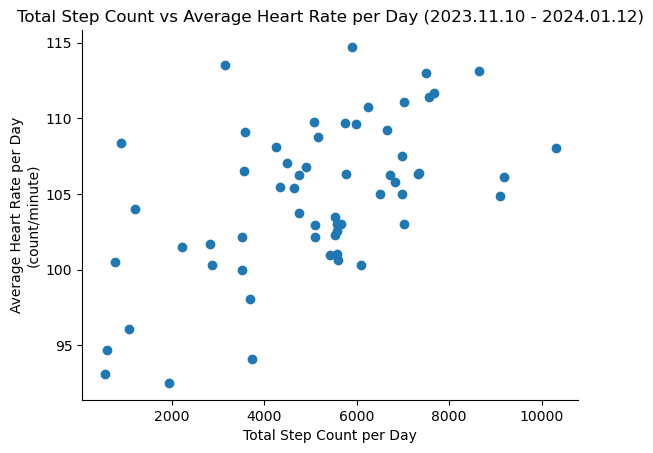

Spearman's rank correlation coefficient: 0.5060783167738166
The correlation is statistically significant: P-value: 4.330119241811917e-05, significance level: 0.05


Pearson correlation coefficient: 0.5461550497565519
The correlation is statistically significant. P-value: 7.664003405112556e-06, significance level: 0.05


In [21]:
daily_heart_rates = []
daily_total_step_count = []
heart_rate_step_count = []

for day, val_list in raw_heart_rates.items():
    daily_count = 0
    total_heart_rate = 0
    total_heart_rate_count = 0
    temp = {}

    for value_pair in val_list:
        for each_step in step_counts[day]:
            if each_step[1] <= value_pair[1] < each_step[2]:
                if each_step[1] not in temp:
                    temp[each_step[1]] = [value_pair[0], 1, each_step[0]]
                else:
                    temp[each_step[1]][0] += value_pair[0]
                    temp[each_step[1]][1] += 1
                break
                
    for key, val in temp.items():
        daily_count += val[2]
        total_heart_rate += val[0]
        total_heart_rate_count += val[1]
    
    if daily_count >= 500:
        daily_total_step_count.append(daily_count)
        daily_heart_rates.append(total_heart_rate / total_heart_rate_count)

daily_heart_rates = np.array(daily_heart_rates)
daily_total_step_count = np.array(daily_total_step_count)

plt.scatter(daily_total_step_count, daily_heart_rates)
plt.title(f'Total Step Count vs Average Heart Rate per Day ({datetime.strftime(starting_date, date_format).replace("-", ".")} - {datetime.strftime(ending_date, date_format).replace("-", ".")})')
plt.xlabel('Total Step Count per Day')
plt.ylabel("Average Heart Rate per Day\n(count/minute)")

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

spearman_rank_correlation(daily_total_step_count, daily_heart_rates, 0.05)
print("\n")
pearson_correlation(daily_total_step_count, daily_heart_rates, 0.05)

## Heart Rate Over Time

<br>

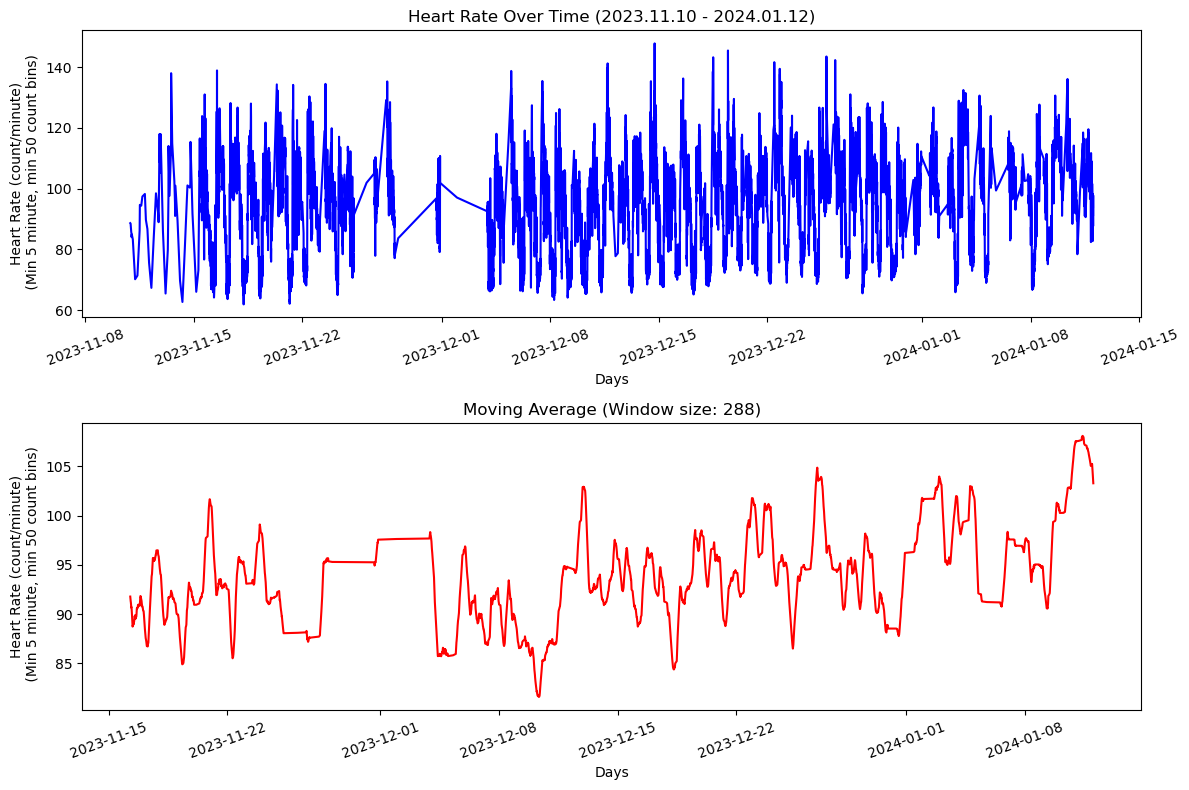

In [22]:
timestamps = []
heart_rate_events = []
for i, j in binned_heart_rates.items():
    for val in j:
        heart_rate_events.append(val[0])
        timestamps.append(val[1])

data = {'Timestamp': timestamps, 'HeartRate': heart_rate_events}
df = pd.DataFrame(data)

df['MovingAverage'] = df['HeartRate'].rolling(window=288).mean()

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(df["Timestamp"], df["HeartRate"], label='Original', color='blue')
plt.title(f'Heart Rate Over Time ({datetime.strftime(starting_date, date_format).replace("-", ".")} - {datetime.strftime(ending_date, date_format).replace("-", ".")})')
plt.xlabel('Days')
plt.ylabel('Heart Rate (count/minute)\n (Min 5 minute, min 50 count bins)')
plt.xticks(rotation=20)

plt.subplot(2, 1, 2)
plt.plot(df["Timestamp"], df["MovingAverage"], color='red')
plt.title('Moving Average (Window size: 288)')
plt.xlabel('Days')
plt.ylabel('Heart Rate (count/minute)\n (Min 5 minute, min 50 count bins)')
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()